In [1]:
import pandas as pd
import numpy as np

import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
from PIL import Image
import zipfile

import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torchvision

import matplotlib.pyplot as plt
import albumentations as albu
import timm
import tqdm

In [2]:
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [3]:
img_size = 512
BATCH_SIZE =24
weights = 'imagenet'
learning_rate = 1e-3
EPOCHS = 10
dropout_rate = 0.2
NUM_WORKERS = 1
PATH = './model_param/'

In [4]:
train_inp_files = glob(f'./data/train_input_img_{img_size}/*.png')
train_targ_files = glob(f'./data/train_label_img_{img_size}/*.png')

val_inp_files = glob(f'./data/val_input_img_{img_size}/*.png')
val_targ_files = glob(f'./data/val_label_img_{img_size}/*.png')

In [5]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)


In [6]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files)

(11620, 2100, 11620, 2100)

In [7]:
x_img = np.array(Image.open(train_inp_files[1030]))
y_img = np.array(Image.open(train_targ_files[1030]))

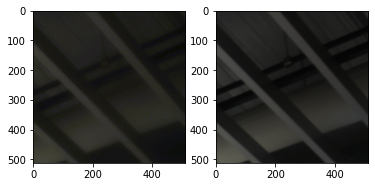

In [8]:
plt.subplot(1,2,1)
plt.imshow(x_img)
plt.subplot(1,2,2)
plt.imshow(y_img)
plt.show()

In [9]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, x, y=None, x_transforms=None, common_transforms=None):
        super().__init__()
        self.x_transforms = x_transforms
        self.common_transforms = common_transforms
        self.x_data = x
        self.y_data = y
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        x = np.array(Image.open(x))
        y = np.array(Image.open(y))

        if self.x_transforms is not None:
            x_transformed = self.x_transforms(image=x)
            x = x_transformed['image']
        
        if self.common_transforms is not None:
            transformed = self.common_transforms(image=x, target_image=y)
            x = transformed['image']
            y = transformed['target_image']
        
        x = Image.fromarray(x)
        y = Image.fromarray(y)

        totensor = T.ToTensor()
        x = totensor(x)
        y = totensor(y)

        return x, y

In [10]:
common_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.Cutout(num_holes=8, max_h_size=50, max_w_size=50, p=1.)
    ],
    additional_targets={'target_image':'image'})

x_transform = albu.Compose([
    albu.Posterize(p=1.),
])

/home/seungjae41/comp/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [11]:
dataset = CustomImageDataset(x=train_inp_files,
                       y=train_targ_files,
                       x_transforms=x_transform,
                       common_transforms=common_transform)

In [12]:
x, y = dataset.__getitem__(100)

In [13]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max = 1.0):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score

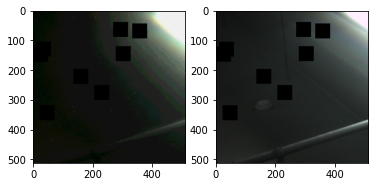

In [14]:
toPIL = T.ToPILImage()
x = toPIL(x)
y = toPIL(y)
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)
plt.show()

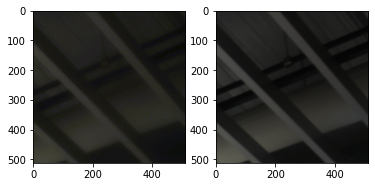

In [15]:
plt.subplot(1,2,1)
plt.imshow(x_img)
plt.subplot(1,2,2)
plt.imshow(y_img)
plt.show()

In [16]:
def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),

    )
    return model

In [17]:
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


SyntaxError: invalid syntax (<ipython-input-17-45580213df07>, line 3)

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

In [ ]:
class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

In [ ]:
class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

In [ ]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)
        
        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
        )
        
            
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [ ]:
in_dim = 3
out_dim = 3
num_filters = 64
num_epoch = 3000
lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
res ={
    'train_psnr':[],
    'val_psnr':[],
}

In [ ]:
def train(model, train_data,val_data, criterion, optimizer, scheduler):
    best_psnr = 0
    for epoch in range(EPOCHS):
        train_running_step = len(train_data)
        print(f'running step: {train_running_step}')
        avg_psnr = 0.0
        idx = 0
        model.train()
        for image, target in tqdm.tqdm(train_data, total=len(train_data)):
            
            image = image.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            recons = model(image)
            loss = criterion(recons, target)
            loss.backward()
            optimizer.step()
            psnr = psnr_score(target.detach().cpu().numpy(), recons.detach().cpu().numpy(), pixel_max=1.0)
            avg_psnr += psnr
            if idx % int(train_running_step/10) == 0:
                print(f'[{epoch}/{EPOCHS}], Loss: {loss.item()}')
            idx += 1

        print(f'\t training psnr: {avg_psnr / train_running_step}')
        res['train_psnr'].append(avg_psnr / train_running_step)
        scheduler.step()
        

        val_running_step = len(val_data)
        print(f'running step: {val_running_step}')
        avg_psnr = 0.0
        idx = 0
        model.eval()
        with torch.no_grad():
            
            for img, tgt in tqdm.tqdm(val_data, total=len(val_data)):
                img = img.cuda()
                tgt = tgt.cuda()

                recons = model(img)
                score = psnr_score(tgt.detach().cpu().numpy(), recons.detach().cpu().numpy())
                avg_psnr += score

                if epoch % 2 ==0:
                    target_path = f'./SAVE_img/{epoch}/'
                    if not os.path.exists(target_path):
                        os.makedirs(target_path, exist_ok=True)
                    
                    grid = torchvision.utils.make_grid(tensor=torch.vstack([img, recons , tgt]), nrow=img.shape[0])
                    torchvision.utils.save_image(grid, target_path+str(idx)+'.png')
                idx += 1
    
            val_psnr = avg_psnr/val_running_step
            print(f'\t Current valid PSNR | BEST PSNR: [{val_psnr}| {best_psnr}]')

            if val_psnr > best_psnr:
                print(print(f'\t Best PSNR changed [{best_psnr} ---> {val_psnr}]'))
                torch.save(model.state_dict(), PATH+f'b3_{epoch}_{val_psnr}_{img_size}')     
                best_psnr = val_psnr

In [ ]:
import EfficientUnet
model = EfficientUnet.EffUNet(3,3).to(device)

In [ ]:
#model = UnetGenerator(in_dim=in_dim, out_dim=out_dim, num_filter=num_filters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)

In [ ]:
train_dataset = CustomImageDataset(x=train_inp_files,
                       y=train_targ_files,
                       x_transforms=x_transform,
                       common_transforms=common_transform)
valid_dataset = CustomImageDataset(x=val_inp_files,
                        y=val_targ_files,
                        )

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [ ]:
train(model, train_dataloader, valid_dataloader, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

running step: 485


  0%|          | 1/485 [00:00<07:39,  1.05it/s]

[0/10], Loss: 0.3521040976047516


 10%|█         | 49/485 [00:43<06:31,  1.11it/s]

[0/10], Loss: 0.015352535992860794


 20%|██        | 97/485 [01:27<05:48,  1.11it/s]

[0/10], Loss: 0.007807055953890085


 30%|██▉       | 145/485 [02:10<05:05,  1.11it/s]

[0/10], Loss: 0.015393381007015705


 40%|███▉      | 193/485 [02:54<04:27,  1.09it/s]

[0/10], Loss: 0.008392460644245148


 50%|████▉     | 241/485 [03:38<03:44,  1.09it/s]

[0/10], Loss: 0.007833612151443958


 60%|█████▉    | 289/485 [04:22<03:01,  1.08it/s]

[0/10], Loss: 0.00499948114156723


 69%|██████▉   | 337/485 [05:07<02:16,  1.09it/s]

[0/10], Loss: 0.005087109282612801


 79%|███████▉  | 385/485 [05:51<01:31,  1.10it/s]

[0/10], Loss: 0.004845486022531986


 89%|████████▉ | 433/485 [06:34<00:47,  1.10it/s]

[0/10], Loss: 0.004403880797326565


 99%|█████████▉| 481/485 [07:18<00:03,  1.10it/s]

[0/10], Loss: 0.006085946690291166


100%|██████████| 485/485 [07:21<00:00,  1.10it/s]


	 training psnr: 20.809233826388223
running step: 88


100%|██████████| 88/88 [08:00<00:00,  5.46s/it]


	 Current valid PSNR | BEST PSNR: [15.65270099988167| 0]
	 Best PSNR changed [0 ---> 15.65270099988167]
None
running step: 485


  0%|          | 1/485 [00:00<07:29,  1.08it/s]

[1/10], Loss: 0.016828782856464386


 10%|█         | 49/485 [00:43<06:32,  1.11it/s]

[1/10], Loss: 0.003578394651412964


 20%|██        | 97/485 [01:27<05:46,  1.12it/s]

[1/10], Loss: 0.008893430233001709


 30%|██▉       | 145/485 [02:10<05:07,  1.10it/s]

[1/10], Loss: 0.0075672767125070095


 40%|███▉      | 193/485 [02:54<04:24,  1.10it/s]

[1/10], Loss: 0.004624548368155956


 50%|████▉     | 241/485 [03:37<03:43,  1.09it/s]

[1/10], Loss: 0.004744437988847494


 60%|█████▉    | 289/485 [04:21<02:58,  1.10it/s]

[1/10], Loss: 0.007307686842978001


 69%|██████▉   | 337/485 [05:05<02:16,  1.09it/s]

[1/10], Loss: 0.005816703196614981


 79%|███████▉  | 385/485 [05:49<01:31,  1.09it/s]

[1/10], Loss: 0.00412707356736064


 89%|████████▉ | 433/485 [06:32<00:47,  1.10it/s]

[1/10], Loss: 0.0028558324556797743


 99%|█████████▉| 481/485 [07:16<00:03,  1.10it/s]

[1/10], Loss: 0.0073635452426970005


100%|██████████| 485/485 [07:19<00:00,  1.10it/s]


	 training psnr: 22.477408441829308
running step: 88


100%|██████████| 88/88 [00:40<00:00,  2.18it/s]


	 Current valid PSNR | BEST PSNR: [20.50633160836675| 15.65270099988167]
	 Best PSNR changed [15.65270099988167 ---> 20.50633160836675]
None
running step: 485


  0%|          | 1/485 [00:00<07:20,  1.10it/s]

[2/10], Loss: 0.006098643876612186


 10%|█         | 49/485 [00:44<06:39,  1.09it/s]

[2/10], Loss: 0.004028273280709982


 20%|██        | 97/485 [01:28<05:54,  1.10it/s]

[2/10], Loss: 0.005256214179098606


 30%|██▉       | 145/485 [02:12<05:09,  1.10it/s]

[2/10], Loss: 0.009692956693470478


 40%|███▉      | 193/485 [02:56<04:25,  1.10it/s]

[2/10], Loss: 0.0035384015645831823


 50%|████▉     | 241/485 [03:40<03:43,  1.09it/s]

[2/10], Loss: 0.0036752985324710608


 60%|█████▉    | 289/485 [04:24<02:58,  1.10it/s]

[2/10], Loss: 0.0038985891733318567


 69%|██████▉   | 337/485 [05:07<02:15,  1.09it/s]

[2/10], Loss: 0.004753343760967255


 79%|███████▉  | 385/485 [05:51<01:31,  1.09it/s]

[2/10], Loss: 0.003533541690558195


 89%|████████▉ | 433/485 [06:35<00:47,  1.10it/s]

[2/10], Loss: 0.006410644389688969


 99%|█████████▉| 481/485 [07:19<00:03,  1.08it/s]

[2/10], Loss: 0.0037546970415860415


100%|██████████| 485/485 [07:22<00:00,  1.10it/s]


	 training psnr: 22.992628111782373
running step: 88


100%|██████████| 88/88 [07:53<00:00,  5.38s/it]


	 Current valid PSNR | BEST PSNR: [23.16499567818188| 20.50633160836675]
	 Best PSNR changed [20.50633160836675 ---> 23.16499567818188]
None
running step: 485


  0%|          | 1/485 [00:00<07:26,  1.08it/s]

[3/10], Loss: 0.0051243980415165424


 10%|█         | 49/485 [00:43<06:32,  1.11it/s]

[3/10], Loss: 0.004395017866045237


 20%|██        | 97/485 [01:26<05:46,  1.12it/s]

[3/10], Loss: 0.0036338837817311287


 30%|██▉       | 145/485 [02:10<05:05,  1.11it/s]

[3/10], Loss: 0.005256695207208395


 40%|███▉      | 193/485 [02:53<04:23,  1.11it/s]

[3/10], Loss: 0.003996549639850855


 50%|████▉     | 241/485 [03:36<03:41,  1.10it/s]

[3/10], Loss: 0.003289338666945696


 60%|█████▉    | 289/485 [04:20<02:57,  1.10it/s]

[3/10], Loss: 0.009649903513491154


 69%|██████▉   | 337/485 [05:04<02:14,  1.10it/s]

[3/10], Loss: 0.006006237585097551


 79%|███████▉  | 385/485 [05:47<01:31,  1.10it/s]

[3/10], Loss: 0.0033007990568876266


 89%|████████▉ | 433/485 [06:31<00:47,  1.10it/s]

[3/10], Loss: 0.0043684192933142185


 99%|█████████▉| 481/485 [07:15<00:03,  1.10it/s]

[3/10], Loss: 0.007686166558414698


100%|██████████| 485/485 [07:17<00:00,  1.11it/s]


	 training psnr: 23.22202012351719
running step: 88


100%|██████████| 88/88 [00:40<00:00,  2.20it/s]


	 Current valid PSNR | BEST PSNR: [20.842882371581453| 23.16499567818188]
running step: 485


  0%|          | 1/485 [00:00<07:21,  1.10it/s]

[4/10], Loss: 0.004928599577397108


 10%|█         | 49/485 [00:44<06:34,  1.11it/s]

[4/10], Loss: 0.009937007911503315


 20%|██        | 97/485 [01:27<05:51,  1.10it/s]

[4/10], Loss: 0.005413284990936518


 30%|██▉       | 145/485 [02:11<05:09,  1.10it/s]

[4/10], Loss: 0.00755084166303277


 40%|███▉      | 193/485 [02:55<04:26,  1.09it/s]

[4/10], Loss: 0.005278020165860653


 50%|████▉     | 241/485 [03:39<03:42,  1.10it/s]

[4/10], Loss: 0.006338518112897873


 60%|█████▉    | 289/485 [04:23<02:59,  1.09it/s]

[4/10], Loss: 0.006668577902019024


 69%|██████▉   | 337/485 [05:06<02:15,  1.10it/s]

[4/10], Loss: 0.0039539635181427


 79%|███████▉  | 385/485 [05:50<01:31,  1.09it/s]

[4/10], Loss: 0.0042959172278642654


 89%|████████▉ | 433/485 [06:34<00:47,  1.09it/s]

[4/10], Loss: 0.004036706406623125


 99%|█████████▉| 481/485 [07:18<00:03,  1.10it/s]

[4/10], Loss: 0.004594019148498774


100%|██████████| 485/485 [07:20<00:00,  1.10it/s]


	 training psnr: 23.422977489706792
running step: 88


100%|██████████| 88/88 [07:47<00:00,  5.32s/it]


	 Current valid PSNR | BEST PSNR: [17.207066454843986| 23.16499567818188]
running step: 485


  0%|          | 1/485 [00:00<07:16,  1.11it/s]

[5/10], Loss: 0.00912901945412159


 10%|█         | 49/485 [00:44<06:29,  1.12it/s]

[5/10], Loss: 0.002912519732490182


 20%|██        | 97/485 [01:27<05:48,  1.11it/s]

[5/10], Loss: 0.004701065830886364


 30%|██▉       | 145/485 [02:10<05:04,  1.12it/s]

[5/10], Loss: 0.006523042917251587


 40%|███▉      | 193/485 [02:53<04:22,  1.11it/s]

[5/10], Loss: 0.007522413972765207


 50%|████▉     | 241/485 [03:37<03:40,  1.11it/s]

[5/10], Loss: 0.003507655579596758


 60%|█████▉    | 289/485 [04:20<02:59,  1.09it/s]

[5/10], Loss: 0.006782723590731621


 69%|██████▉   | 337/485 [05:04<02:14,  1.10it/s]

[5/10], Loss: 0.003379279049113393


 79%|███████▉  | 385/485 [05:47<01:30,  1.10it/s]

[5/10], Loss: 0.002906567882746458


 89%|████████▉ | 433/485 [06:31<00:47,  1.10it/s]

[5/10], Loss: 0.0036589023657143116


 99%|█████████▉| 481/485 [07:15<00:03,  1.09it/s]

[5/10], Loss: 0.0031520158518105745


100%|██████████| 485/485 [07:18<00:00,  1.11it/s]


	 training psnr: 23.551527610457875
running step: 88


100%|██████████| 88/88 [00:40<00:00,  2.19it/s]


	 Current valid PSNR | BEST PSNR: [22.818422427662384| 23.16499567818188]
running step: 485


  0%|          | 1/485 [00:00<07:13,  1.12it/s]

[6/10], Loss: 0.0027732299640774727


 10%|█         | 49/485 [00:44<06:33,  1.11it/s]

[6/10], Loss: 0.004400382284075022


 20%|██        | 97/485 [01:28<05:53,  1.10it/s]

[6/10], Loss: 0.00440133037045598


 30%|██▉       | 145/485 [02:12<05:09,  1.10it/s]

[6/10], Loss: 0.0037968228571116924


 40%|███▉      | 193/485 [02:56<04:26,  1.10it/s]

[6/10], Loss: 0.003957080189138651


 50%|████▉     | 241/485 [03:40<03:40,  1.11it/s]

[6/10], Loss: 0.004032169934362173


 60%|█████▉    | 289/485 [04:23<02:59,  1.09it/s]

[6/10], Loss: 0.0030422136187553406


 69%|██████▉   | 337/485 [05:07<02:15,  1.09it/s]

[6/10], Loss: 0.0028259665705263615


 79%|███████▉  | 385/485 [05:51<01:31,  1.10it/s]

[6/10], Loss: 0.0030990669038146734


 89%|████████▉ | 433/485 [06:35<00:47,  1.09it/s]

[6/10], Loss: 0.0030829613097012043


 99%|█████████▉| 481/485 [07:19<00:03,  1.10it/s]

[6/10], Loss: 0.00667494535446167


100%|██████████| 485/485 [07:22<00:00,  1.10it/s]


	 training psnr: 23.947585171874692
running step: 88


100%|██████████| 88/88 [07:52<00:00,  5.37s/it]


	 Current valid PSNR | BEST PSNR: [22.683516583592205| 23.16499567818188]
running step: 485


  0%|          | 1/485 [00:00<07:15,  1.11it/s]

[7/10], Loss: 0.005511041730642319


 10%|█         | 49/485 [00:43<06:36,  1.10it/s]

[7/10], Loss: 0.002757672918960452


 20%|██        | 97/485 [01:27<05:50,  1.11it/s]

[7/10], Loss: 0.0024080544244498014


 25%|██▌       | 122/485 [01:50<05:27,  1.11it/s]


KeyboardInterrupt: 

In [ ]:
import EfficientUnet
model = EfficientUnet.EffUNet(3,3).to(device)

In [ ]:
model.load_state_dict(torch.load('./model_param/effnet_23.pth'))

<All keys matched successfully>

In [ ]:
Testset = glob(f'./Data/test/test_input_*.png')